## Semi-synthetic 20newsgroups dataset

In this notebook, we run NMF, LDA, NCPD, and Online NCPD as dynamic topic modeling techniques for the semi-synthetic 20newsgroups dataset described in the paper.

### Standard Imports

In [4]:
random.seed(1)
rank = 5
n_top_words = 5 # number of keywords to display for each topic
save_figures = True
load_NMF_factors = False # True for loading pre-saved NMF factors; False for computing the factors
load_NCPD_factors = False # True for loading pre-saved NCPD factors; False for computing the factors
load_lda_model = False # True for loading trained LDA model; False for training a model
load_ONCPD_factors = False # True for loading pre-saved ONCPD factors; False for computing the factors
local_path = results_dir

In [20]:
import os
import numpy as np
import pickle 
import pandas as pd
import tensorly as tl
import nltk
import gensim
import random
import collections 
from gensim import corpora,models
from nltk.corpus import stopwords
from tensorly import fold
from sklearn.datasets import fetch_20newsgroups
from tensorly.decomposition import non_negative_parafac
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import seaborn as sns
import matplotlib.pyplot as plt
from config import data_dir, results_dir
nltk.download('stopwords')
#from covid19 import plotting, utils
#from covid19.online_CPDL.ocpdl import Online_CPDL

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andiaye2\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

### Load  20newsgroups dataset

In [21]:
# Download the data with the selected categories
remove_tuple = ('headers', 'footers', 'quotes') # remove headers, footers, and quotes from all documents
newsgroups_subset_atheism = fetch_20newsgroups(subset='all', categories=['alt.atheism'], shuffle=True, random_state = 1, 
                                               remove=remove_tuple)
newsgroups_subset_space = fetch_20newsgroups(subset='all', categories=['sci.space'], shuffle=True, random_state = 1,
                                               remove=remove_tuple)
newsgroups_subset_forsale = fetch_20newsgroups(subset='all', categories= ['misc.forsale'], shuffle=True, random_state = 1,
                                               remove=remove_tuple)
newsgroups_subset_baseball = fetch_20newsgroups(subset='all', categories=['rec.sport.baseball'], shuffle=True, random_state =1,
                                               remove=remove_tuple)
newsgroups_subset_windowsx = fetch_20newsgroups(subset='all', categories=['comp.windows.x'], shuffle=True, random_state = 1,
                                               remove=remove_tuple)

In [22]:
# Find the minimum number of documents for each category
min_doc = np.min([len(newsgroups_subset_atheism.data),
                  len(newsgroups_subset_space.data), 
                  len(newsgroups_subset_forsale.data), 
                  len(newsgroups_subset_baseball.data),
                  len(newsgroups_subset_windowsx.data)])
print(min_doc)

799


In [23]:
doc_slice_lock = 26 # number of documents per slice

numb_A = 2 #number of time slices from aethism category
numb_S = 18 #number of time slices from space category
numb_B_1 = 3 #number of time slices from baseball category for the first instance
numb_F = 12 #number of time slices from sale category
numb_W = 2 #number of time slices from Windows X category
numb_B_2 = 3 #number of time slices from baseball category for the second instance

numb_B = numb_B_1 + numb_B_2

num_time_slices = numb_A + numb_B + numb_S + numb_F + numb_W
print(num_time_slices)

40


In [24]:
# Subsample each category based on the outline above
data_samples_atheism = newsgroups_subset_atheism.data[:numb_A*doc_slice_lock]
data_samples_space = newsgroups_subset_space.data[:numb_S*doc_slice_lock]
data_samples_forsale = newsgroups_subset_forsale.data[:numb_F*doc_slice_lock]
data_samples_baseball = newsgroups_subset_baseball.data[:numb_B*doc_slice_lock]
data_samples_windowsx = newsgroups_subset_windowsx.data[:numb_W*doc_slice_lock]

In [25]:
# Corpus from all categories in order atheism, space, forsale, baseball
newsgroups_subset_cats = data_samples_atheism + data_samples_space + data_samples_forsale + data_samples_baseball + data_samples_windowsx
print(f"Total number of documents in all categories is {len(newsgroups_subset_cats)}.")

Total number of documents in all categories is 1040.


### Extract TF-IDF weights and features

In [27]:
# Vary the choices of the parameters of TfidfVectorizer
n_features = 5000
max_df=0.95
stop_words_list = nltk.corpus.stopwords.words('english')
vectorizer = TfidfVectorizer(max_df=max_df, max_features=n_features,
                            stop_words=stop_words_list)
vectors = vectorizer.fit_transform(newsgroups_subset_cats) 
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = np.array(dense).transpose() 

In [28]:
# List of all features/words extracted
feature_names

['00',
 '000',
 '00000',
 '01',
 '02',
 '02106',
 '03',
 '04',
 '05',
 '05pm',
 '06',
 '0674',
 '07',
 '08',
 '09',
 '10',
 '100',
 '1000',
 '100ns',
 '101',
 '102',
 '1024x768',
 '104',
 '105',
 '11',
 '111',
 '117',
 '119',
 '12',
 '120',
 '1200',
 '122',
 '125',
 '127',
 '128',
 '129',
 '13',
 '130',
 '1300',
 '131',
 '132',
 '133',
 '134',
 '135',
 '137',
 '138',
 '139',
 '14',
 '140',
 '141',
 '142',
 '143',
 '144',
 '146',
 '147',
 '149',
 '15',
 '150',
 '1500',
 '152',
 '158',
 '159',
 '15m',
 '15th',
 '16',
 '160',
 '1600',
 '164',
 '169',
 '17',
 '170',
 '175',
 '18',
 '180',
 '18084tm',
 '183',
 '184',
 '187',
 '189',
 '19',
 '192',
 '194',
 '195',
 '1959',
 '196',
 '1960',
 '1962',
 '1964',
 '1965',
 '1969',
 '1970',
 '1971',
 '1972',
 '1975',
 '1976',
 '1978',
 '1979',
 '1980',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1999',
 '1g',
 '1st',
 '20',
 '200',
 '2000'

## Organize the dataset into a dynamic tensor

In [29]:
# Features matrix shape
print("Shape of feature matrix {}.".format(denselist.shape))
print("Dimensions: (vocabulary, headlines)")

Shape of feature matrix (5000, 1040).
Dimensions: (vocabulary, headlines)


In [30]:
# Separate each category
X_aethism = denselist[:,0:numb_A*doc_slice_lock]
print(X_aethism.shape)

X_space = denselist[:,numb_A*doc_slice_lock:(numb_A+numb_S)*doc_slice_lock]
print(X_space.shape)

X_forsale = denselist[:,(numb_A+numb_S)*doc_slice_lock:(numb_A+numb_S+numb_F)*doc_slice_lock]
print(X_forsale.shape)

X_baseball = denselist[:,(numb_A+numb_S+numb_F)*doc_slice_lock:(numb_A+numb_S+numb_F+numb_B)*doc_slice_lock]
print(X_baseball.shape)

X_windowsx = denselist[:,(numb_A+numb_S+numb_F+numb_B)*doc_slice_lock:(numb_A+numb_S+numb_F+numb_B+numb_W)*doc_slice_lock]
print(X_windowsx.shape)

(5000, 52)
(5000, 468)
(5000, 312)
(5000, 156)
(5000, 52)


In [31]:
# Check if the splitting was done properly
np.all(np.concatenate((X_aethism, X_space, X_forsale, X_baseball, X_windowsx), axis = 1) == denselist)

True

In [32]:
# Organize each category into a tensor of dimensions: (documents, vocabulary, time)
X_aethism_tens = fold(X_aethism, 1, (X_aethism.shape[1] // numb_A, X_aethism.shape[0], numb_A))
X_aethism_tens = X_aethism_tens[:, :, 0:numb_A]
print(X_aethism_tens.shape)

X_space_tens = fold(X_space, 1, (X_space.shape[1] // numb_S, X_space.shape[0], numb_S))
X_space_tens = X_space_tens[:, :, 0:numb_S]
print(X_space_tens.shape)

X_baseball_tens = fold(X_baseball, 1, (X_baseball.shape[1] // numb_B, X_baseball.shape[0], numb_B))
X_baseball_tens = X_baseball_tens[:, :, 0:numb_B_1]
print(X_baseball_tens.shape)

X_forsale_tens = fold(X_forsale, 1, (X_forsale.shape[1] // numb_F, X_forsale.shape[0], numb_F))
X_forsale_tens = X_forsale_tens[:, :, 0:numb_F]
print(X_forsale_tens.shape)

X_windowsx_tens = fold(X_windowsx, 1, (X_windowsx.shape[1] // numb_W, X_windowsx.shape[0], numb_W))
X_windowsx_tens = X_windowsx_tens[:, :, 0:numb_W]
print(X_windowsx_tens.shape)

X_baseball_tens_2 = fold(X_baseball, 1, (X_baseball.shape[1] // numb_B, X_baseball.shape[0], numb_B))
X_baseball_tens_2 = X_baseball_tens_2[:, :, numb_B_1:numb_B_1+numb_B_2]
print(X_baseball_tens_2.shape)

(26, 5000, 2)
(26, 5000, 18)
(26, 5000, 3)
(26, 5000, 12)
(26, 5000, 2)
(26, 5000, 3)


In [33]:
# Tensor Dataset
tensor_20news = np.concatenate((X_aethism_tens, X_space_tens, X_baseball_tens, X_forsale_tens, X_windowsx_tens, X_baseball_tens_2) , axis = 2).T
print("Shape of the tensor {}.".format(tensor_20news.shape)) 
print("Dimensions: (time, vocabulary, documents)")

Shape of the tensor (40, 5000, 26).
Dimensions: (time, vocabulary, documents)


In [34]:
# Heatmap Visualization
sns.set(style="whitegrid", font_scale=1.5, context="talk")

def heatmap(
    data,
    x_tick_labels=None,
    x_label="",
    y_tick_labels=None,
    y_label="",
    figsize=(7, 9),
    max_data=None,
):
    """Plot heatmap.
    Args:
        data: (2d array) data to be plotted (topics x date)
        x_tick_labels (list of str)
    Returns:
        fig
        ax
    """

    fig = plt.figure(figsize=figsize)
    ax = sns.heatmap(
        data,
        rasterized=True,
        vmax=max_data,
        cbar_kws=dict(use_gridspec=False, location="top"),
    )

    plt.xticks(rotation=45)
    plt.yticks(np.arange(0, data.shape[0], 1.0) + 0.5, rotation=0)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    if y_tick_labels is None:
        y_tick_labels = [topic_num + 1 for topic_num in range(data.shape[0])]
    ax.set_yticklabels(y_tick_labels)

    if x_tick_labels is not None:
        labels = [x_tick_labels[int(item.get_text())] for item in ax.get_xticklabels()]
        ax.set_xticklabels(labels)

    return fig, ax

### Run NMF

In [35]:
# Organized matrix dataset
matrix_20news = np.concatenate(tensor_20news, 1)
print("Shape of matrix {}.".format(matrix_20news.shape))
print("Dimensions: (vocabulary, documents)")

Shape of matrix (5000, 1040).
Dimensions: (vocabulary, documents)


In [36]:
# Run NMF
if load_NMF_factors:
    W, H = pickle.load(open(os.path.join(local_path,"20news_NMF_factors.pickle"), "rb"))
else:
    nmf = NMF(n_components=rank, init='nndsvd', max_iter = 400)
    W = nmf.fit_transform(matrix_20news) # Dictionary
    H = nmf.components_ # Topic representations
    NMF_factors = W,H
    with open(os.path.join(local_path,"20news_NMF_factors.pickle"), "wb") as f:
        pickle.dump(NMF_factors, f)

In [37]:
# Display topics 
for topic_idx, topic in enumerate(W.T):
    message = "Topic %d: " % (topic_idx+1)
    message += ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(message)

Topic 1: would, like, think, one, get
Topic 2: drive, sale, offer, please, email
Topic 3: space, shuttle, nasa, launch, mission
Topic 4: 00, 20, 50, 10, art
Topic 5: mac, hm, 2178, 9591, 336


In [38]:
# Get topic distributions for each time slice
topics_over_time = np.split(H, num_time_slices, axis=1)

# Average topic distributions over time.
avg_topics_over_time = [np.mean(topics, axis=1) for topics in topics_over_time]

# Normalize to get the distribution over topics for each day.
avg_topics_over_time = np.array(
    [topics / np.sum(topics) for topics in avg_topics_over_time]
)

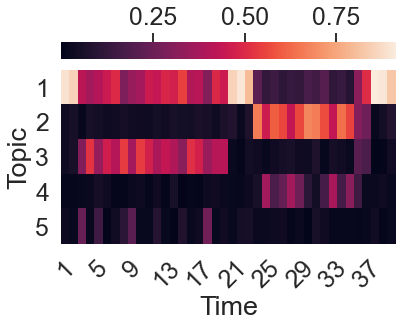

In [39]:
#Visualize topic distributions
date_strs = [str(x+1) for x in range(tensor_20news.shape[0])]

y_tick_labels = ["{}".format(i + 1) for i in range(rank)]

fig, ax = heatmap(
    avg_topics_over_time.T,
    x_tick_labels=date_strs,
    x_label="Time",
    y_tick_labels=y_tick_labels,
    y_label="Topic",
    figsize = (6,4),
)

if save_figures:
    plt.savefig(os.path.join(local_path,"NMF_Normalized_Topic_Time_20news.png"), bbox_inches = 'tight', pad_inches = 0)
plt.show()

## Run NCPD

In [40]:
if load_NCPD_factors:
    factors = pickle.load(open(os.path.join(local_path,"20news_NCPD_factors.pickle"), "rb"))
    weights = pickle.load(open(os.path.join(local_path,"20news_NCPD_weights.pickle"), "rb"))
else:
    factors = non_negative_parafac(tensor_20news, rank=rank, init = 'svd') 
    if len(factors) == 2:
        weights, factors = factors
        print(weights)
        with open(os.path.join(local_path,"20news_NCPD_weights.pickle"), "wb") as f:
            pickle.dump(weights, f)
    with open(os.path.join(local_path,"20news_NCPD_factors.pickle"), "wb") as f:
        pickle.dump(factors, f)

[1. 1. 1. 1. 1.]


In [41]:
# Obtain the shape of the factor matrices
for i in range(len(factors)):
    print(factors[i].shape)

(40, 5)
(5000, 5)
(26, 5)


In [42]:
# Display topics
for topic_idx, topic in enumerate(factors[1].T):
    message = "Topic %d: " % (topic_idx+1)
    message += ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(message)

Topic 1: space, would, like, one, nasa
Topic 2: sale, 00, drive, new, offer
Topic 3: 00, 25, colors, intel, 942
Topic 4: games, game, year, team, baseball
Topic 5: window, widget, application, color, bitmap


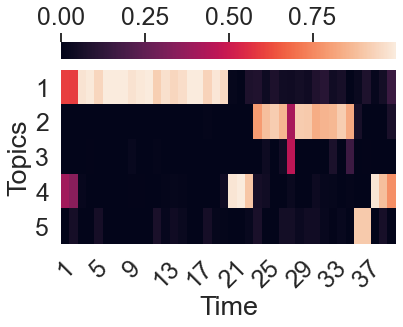

In [45]:
# Plotting normalized temporal factor
time_norm = factors[0]/factors[0].sum(axis=1)[:,None] # row sum equal to 1
y_tick_labels = ["{}".format(i + 1) for i in range(rank)]

fig, ax = heatmap(
    time_norm.T, #factors[2].T for un-normalized factor
    x_tick_labels=date_strs,
    x_label="Time",
    y_tick_labels=y_tick_labels,
    y_label="Topics",
    figsize = (6,4),
)


if save_figures:
    plt.savefig(os.path.join(local_path,"NCPD_Normalized_Topic_Time_20news.png"), bbox_inches = 'tight', pad_inches = 0)
plt.show()

## Run LDA + Temporal evolution extraction

In [46]:
# Structured corpus based on constructed tensor
corpus = data_samples_aethism + data_samples_space + data_samples_baseball[0:numb_B_1*doc_slice_lock] + \
            data_samples_forsale + data_samples_windowsx + \
            data_samples_baseball[numb_B_1*doc_slice_lock:(numb_B_1+numb_B_2)*doc_slice_lock]
len(corpus)

1040

In [47]:
# Data Preprocessing
tokenized_docs = list(map(vectorizer.build_analyzer(),corpus)) # pre-process and tokenize documents using tfidfvectorizer
# Filter processed_docs based on features list
processed_docs = []
for doc in tokenized_docs:
    processed_docs.append([wd_str for wd_str in doc if(wd_str in feature_names)])

dictionary = gensim.corpora.Dictionary(processed_docs) # define a (gensim) dictionary
print(len(dictionary))

# Create bag-of-words corpus (gensim format)
corpus=[dictionary.doc2bow(doc) for doc in processed_docs]

5000


In [48]:
# Alternative Preprocessing (to create a separate dictionary from NMF/NCPD)
"""
# Data Preprocessing
processed_docs = list(map(vectorizer.build_analyzer(),corpus)) # pre-process and tokenize documents using tfidfvectorizer
dictionary = gensim.corpora.Dictionary(processed_docs) # define a (gensim) dictionary
dictionary.filter_extremes(no_below=min_df,no_above=max_df,keep_n=n_features) # use the same parameters as tfidfvectorizer
print(len(dictionary))

# Create bag-of-words corpus (gensim format)
corpus=[dictionary.doc2bow(doc) for doc in processed_docs]
"""

'\n# Data Preprocessing\nprocessed_docs = list(map(vectorizer.build_analyzer(),corpus)) # pre-process and tokenize documents using tfidfvectorizer\ndictionary = gensim.corpora.Dictionary(processed_docs) # define a (gensim) dictionary\ndictionary.filter_extremes(no_below=min_df,no_above=max_df,keep_n=n_features) # use the same parameters as tfidfvectorizer\nprint(len(dictionary))\n\n# Create bag-of-words corpus (gensim format)\ncorpus=[dictionary.doc2bow(doc) for doc in processed_docs]\n'

In [49]:
# Check if dictionaries are the same
collections.Counter(list(dictionary.values())) == collections.Counter(feature_names)

True

In [50]:
# Run LDA
run_LDA_tfidf = False

if run_LDA_tfidf:
    # Convert BOW Corpus to TFIDF Corpus
    tfidf=models.TfidfModel(corpus)
    corpus=tfidf[corpus]

if load_lda_model:
    lda_model = pickle.load(open(os.path.join(local_path,"20news_lda_model.pickle"), "rb"))
else:
    lda_model = gensim.models.LdaModel(corpus,
                                    num_topics=rank, 
                                    id2word = dictionary, 
                                    passes = 20,
                                    minimum_probability = 0,
                                    random_state = 13
                                      )
   
    with open(os.path.join(local_path,"20news_lda_model.pickle"), "wb") as f:
        pickle.dump(lda_model, f)  

In [51]:
# Display topics
for topic_idx, topic in enumerate(lda_model.get_topics()):
    message = "Topic %d: " % (topic_idx+1)
    message += ", ".join([dictionary[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(message)

Topic 1: would, like, one, space, think
Topic 2: edu, use, window, system, subject
Topic 3: space, launch, nasa, shuttle, mission
Topic 4: new, sale, please, one, offer
Topic 5: 00, 50, 20, 10, 40


In [52]:
# LDA representation matrix (topics by documents)
lda_rep_mat = np.empty((rank, len(corpus)))
for numb in range(len(corpus)):
    for index, score in lda_model.get_document_topics(corpus[numb], minimum_probability = 0):
        lda_rep_mat[index, numb] = score

In [53]:
# Get topic distributions for each time slice
lda_topics_over_time = np.split(lda_rep_mat, num_time_slices, axis=1)

# Average topic distributions over time.
lda_avg_topics_over_time = [np.mean(topics, axis=1) for topics in lda_topics_over_time]

# Normalize to get the distribution over topics for each day.
lda_avg_topics_over_time = np.array(
    [topics / np.sum(topics) for topics in lda_avg_topics_over_time]
)

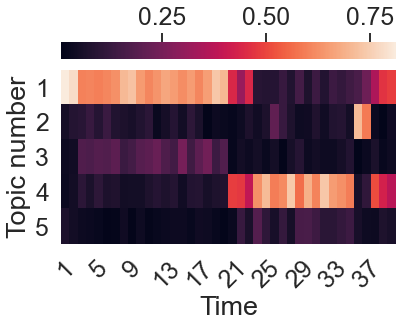

In [54]:
#Visualize topic distributions
y_tick_labels = ["{}".format(i + 1) for i in range(rank)]

fig, ax = heatmap(
    lda_avg_topics_over_time.T,
    x_tick_labels=date_strs,
    x_label="Time",
    y_tick_labels=y_tick_labels,
    y_label="Topic number",
    figsize = (6,4),
)

if save_figures:
    plt.savefig(os.path.join(local_path,"LDA_Normalized_Topic_Time_20news.png"), bbox_inches = 'tight', pad_inches = 0)
plt.show()


## Online NCPD

In [56]:
# SVD intialization (Optional)
weights, factors = non_negative_parafac(tensor_20news, rank=rank, init = 'svd', n_iter_max=1) 
print(factors[0].shape)
print(factors[1].shape)
loading = {}
loading.update({'U0':factors[0]})
loading.update({'U1':factors[1]})

(40, 5)
(5000, 5)


In [62]:
# Run Online NCPD
if load_ONCPD_factors:
    factors = pickle.load(open(os.path.join(local_path,"20news_ONCPD_factors.pickle"), "rb"))
else:
    OCPDL = Online_CPDL(X=tensor_20news,
                        batch_size=tensor_20news.shape[-1]//10,
                        iterations=300,
                        n_components=rank,
                        ini_loading=loading,
                        ini_A=None,
                        ini_B=None,
                        alpha=0,
                        beta=1,
                        subsample=True)
    
    result_dict = OCPDL.train_dict(if_compute_recons_error=False,
                                   save_folder=None,
                                   output_results=True)
    loading = result_dict.get("loading")
    factors = []
    for i in loading.keys():
        factors.append(loading.get(str(i)))
    
    print('!!! X.shape', tensor_20news.shape)
    with open(os.path.join(local_path,"20news_ONCPD_factors.pickle"), "wb") as f:
        pickle.dump(factors, f)

NameError: name 'Online_CPDL' is not defined

In [63]:
# Obtain the shape of the factor matrices
for i in range(len(factors)):
    print(factors[i].shape)

(40, 5)
(5000, 5)
(26, 5)


In [64]:
# Display topics
for topic_idx, topic in enumerate(factors[1].T):
    message = "Topic %d: " % (topic_idx+1)
    message += ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(message)

Topic 1: would, space, like, one, get
Topic 2: 00, sale, drives, drive, new
Topic 3: lh, 00, research, america, margin
Topic 4: game, clemens, cubs, 00, rangers
Topic 5: mac, application, window, looking, thanks


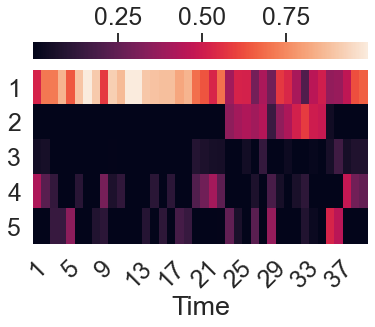

In [65]:
#Visualize topic distributions
date_strs = [str(x+1) for x in range(tensor_20news.shape[0])]

time_norm = factors[0]/factors[0].sum(axis=1)[:,None] # row sum equal to 1
y_tick_labels = ["{}".format(i + 1) for i in range(rank)]

fig, ax = heatmap(
    time_norm.T, #factors[2].T for un-normalized factor
    x_tick_labels=date_strs,
    x_label="Time",
    y_tick_labels=y_tick_labels,
    y_label="",
    figsize = (6,4),
)


if save_figures:
    plt.savefig(os.path.join(local_path,"ONCPD_Normalized_Topic_Time_20news.png"), bbox_inches = 'tight', pad_inches = 0)
plt.show()